In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/a2_glove.6B.100d.txt
/kaggle/input/dataset/a3_IMDb_Unseen_Reviews.csv
/kaggle/input/dataset/a1_IMDB_Dataset.csv


In [2]:
!pip install keras

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

In [3]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

# Updated Keras imports
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

2025-06-08 06:57:59.217748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749365879.245159    1075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749365879.253145    1075 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading dataset

In [4]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("/kaggle/input/dataset/a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [5]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

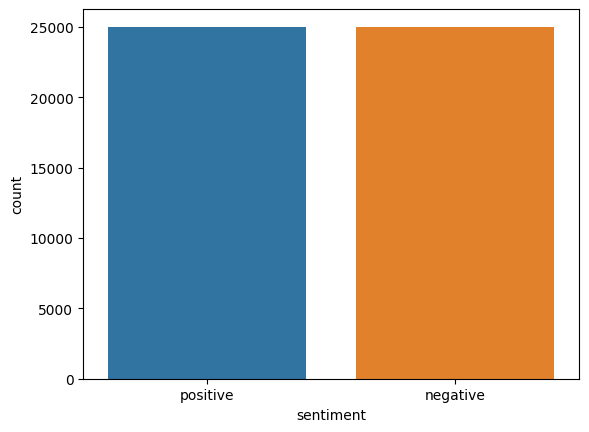

In [8]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [9]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [15]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs ""

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [17]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [19]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/dataset/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [23]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1749365926.685156    1075 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749365926.686038    1075 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [24]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [25]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


I0000 00:00:1749365928.750014    1131 service.cc:148] XLA service 0x7ccd44006250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749365928.750059    1131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749365928.750063    1131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749365928.859429    1131 cuda_dnn.cc:529] Loaded cuDNN version 90300


 67/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5872 - loss: 0.6824

I0000 00:00:1749365929.187343    1131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.6592 - loss: 0.6131 - val_acc: 0.7550 - val_loss: 0.5049
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7969 - loss: 0.4464 - val_acc: 0.7663 - val_loss: 0.4944
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8250 - loss: 0.4010 - val_acc: 0.7570 - val_loss: 0.5088
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8389 - loss: 0.3773 - val_acc: 0.7588 - val_loss: 0.5176
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8422 - loss: 0.3644 - val_acc: 0.7614 - val_loss: 0.5213
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8547 - loss: 0.3451 - val_acc: 0.7511 - val_loss: 0.5481


In [26]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7395 - loss: 0.5789


In [27]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.579638659954071
Test Accuracy: 0.741599977016449


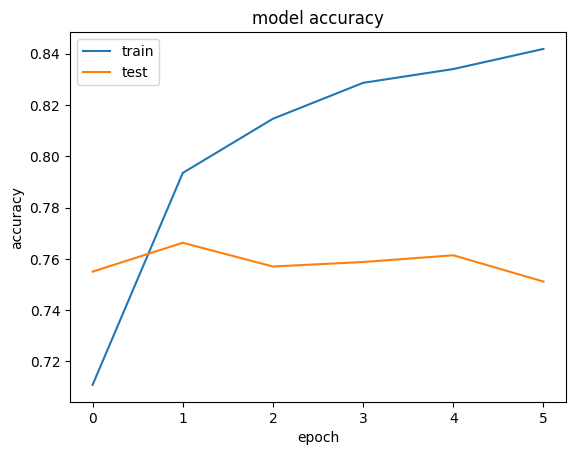

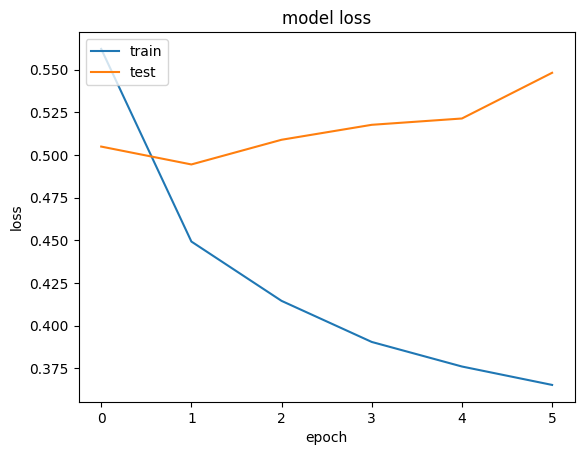

In [28]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [29]:
from keras.layers import Conv1D

In [30]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [31]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [32]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6997 - loss: 0.5713 - val_acc: 0.8359 - val_loss: 0.3797
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8534 - loss: 0.3462 - val_acc: 0.8493 - val_loss: 0.3455
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8897 - loss: 0.2849 - val_acc: 0.8466 - val_loss: 0.3511
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9164 - loss: 0.2358 - val_acc: 0.8529 - val_loss: 0.3285
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9369 - loss: 0.1959 - val_acc: 0.8533 - val_loss: 0.3295
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9563 - loss: 0.1571 - val_acc: 0.8550 - val_loss: 0.3339


In [33]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.8569 - loss: 0.3358


In [34]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3402949571609497
Test Accuracy: 0.8532999753952026


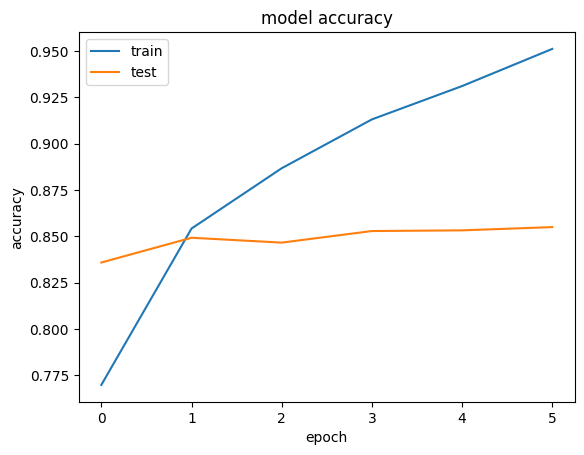

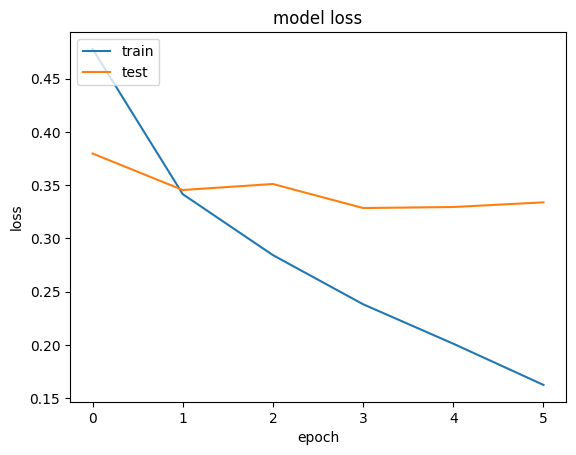

In [35]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [36]:
from keras.layers import LSTM

In [37]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [39]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - acc: 0.6686 - loss: 0.5844 - val_acc: 0.8114 - val_loss: 0.4239
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.8010 - loss: 0.4429 - val_acc: 0.8179 - val_loss: 0.4004
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.8266 - loss: 0.3942 - val_acc: 0.8401 - val_loss: 0.3719
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.8501 - loss: 0.3530 - val_acc: 0.8565 - val_loss: 0.3508
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8673 - loss: 0.3249 - val_acc: 0.8635 - val_loss: 0.3269
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8735 - loss: 0.3077 - val_acc: 0.8428 - val_loss: 0.3482


In [40]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8388 - loss: 0.3495


In [41]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34924280643463135
Test Accuracy: 0.8343999981880188


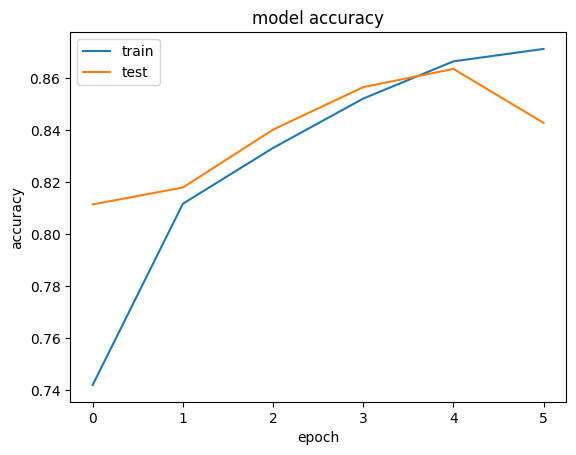

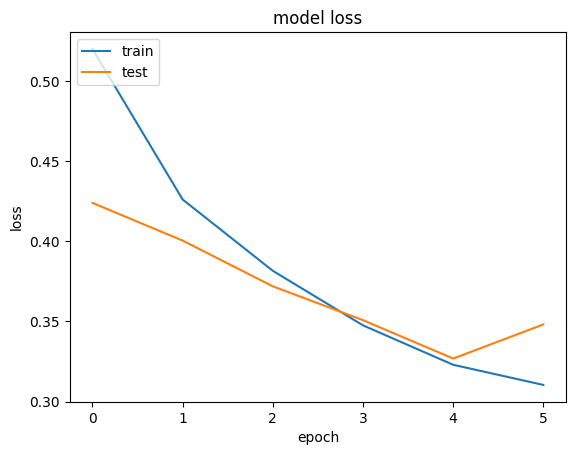

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Bidirectional LSTM (NEW)

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [44]:
# --- Updated maxlen ---
maxlen = 200

# --- Re-pad sequences if changed maxlen ---
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [45]:
# --- Build improved LSTM model ---
lstm_model_new = Sequential()

# Embedding layer (trainable=True)
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

lstm_model_new.add(embedding_layer)

# Bidirectional LSTM with Dropout
lstm_model_new.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
lstm_model_new.add(Dropout(0.5))

# Output layer
lstm_model_new.add(Dense(1, activation='sigmoid'))

In [46]:
# Compile with Adam optimizer and reduced LR
lstm_model_new.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['acc'])

# Show summary
print(lstm_model_new.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 9,239,400 (35.25 MB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
lstm_model_new_history = lstm_model_new.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 175s 656ms/step - acc: 0.6137 - loss: 0.6358 - val_acc: 0.8232 - val_loss: 0.4270
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 163s 651ms/step - acc: 0.8085 - loss: 0.4422 - val_acc: 0.8546 - val_loss: 0.3626
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 644ms/step - acc: 0.8497 - loss: 0.3637 - val_acc: 0.8664 - val_loss: 0.3445
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 160s 638ms/step - acc: 0.8784 - loss: 0.3041 - val_acc: 0.8711 - val_loss: 0.3171
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 159s 636ms/step - acc: 0.9030 - loss: 0.2518 - val_acc: 0.8802 - val_loss: 0.3120
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 632ms/step - acc: 0.9215 - loss: 0.2122 - val_acc: 0.8876 - val_loss: 0.2920
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 631ms/step - acc: 0.9369 - loss: 0.1730 - val_acc: 0.8874 - val_loss: 0.2999
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - acc: 0.9524 - loss: 0.1353 - val_acc: 0.8798 - val_loss: 0.3331
Epoch 9/10
250/250 ━━━━━

In [48]:
# Evaluate the model
score = lstm_model_new.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - acc: 0.8810 - loss: 0.2912
Test Score: 0.2955884635448456
Test Accuracy: 0.8824999928474426


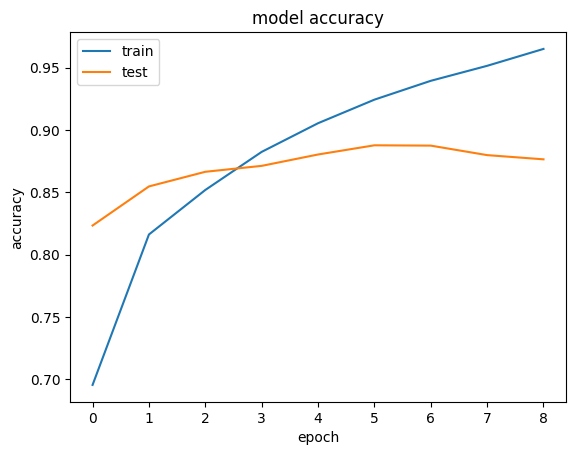

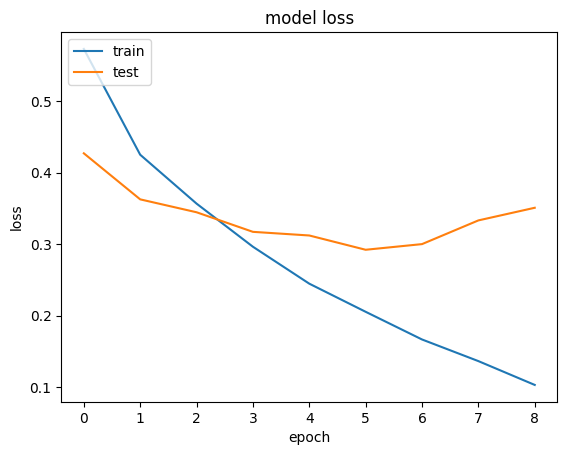

In [49]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_new_history.history['acc'])
plt.plot(lstm_model_new_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_new_history.history['loss'])
plt.plot(lstm_model_new_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [50]:
# Save the improved LSTM model to an HDF5 file
lstm_model_new.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')
print(f"Model saved as c1_lstm_model_acc_{round(score[1], 3)}.h5")


Model saved as c1_lstm_model_acc_0.882.h5


# Making Predictions on Live IMDb data

In [51]:
!ls # lists files in working directory

c1_lstm_model_acc_0.882.h5


In [52]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/kaggle/input/dataset/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [53]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [54]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [55]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model_new.predict(unseen_padded)
unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.9941401 ],
       [0.99068165],
       [0.00700228],
       [0.05984956],
       [0.997747  ],
       [0.00517155]], dtype=float32)

In [56]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,10.0
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
